In [1]:
# %reset 
import numpy as np
import scipy
from skimage import morphology, io
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/Users/xiaolihe/Documents/Computer-Vision-534/hw2")
import pdb
%pylab inline
%pbd on

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
ERROR:root:Line magic function `%pbd` not found.


Populating the interactive namespace from numpy and matplotlib


In [2]:
%pdb on

Automatic pdb calling has been turned ON


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


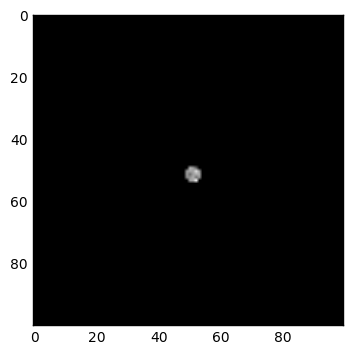

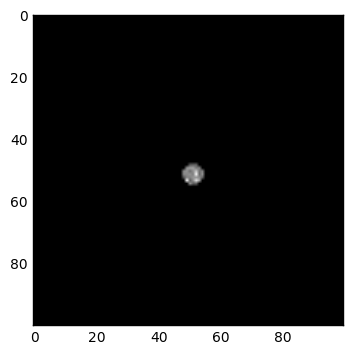

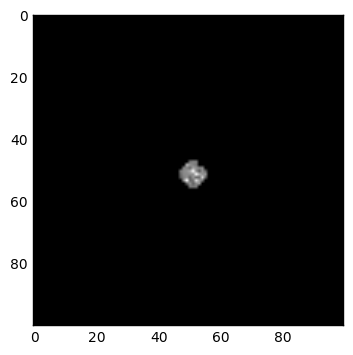

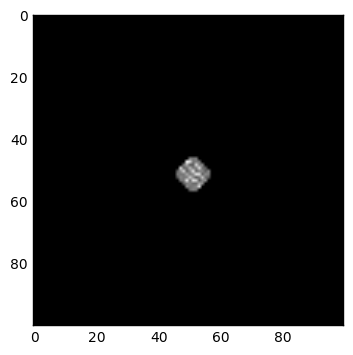

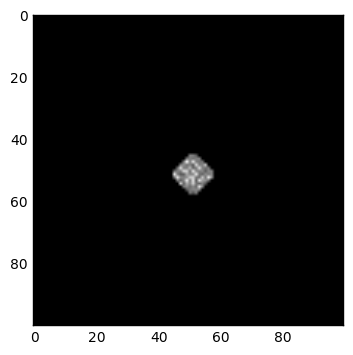

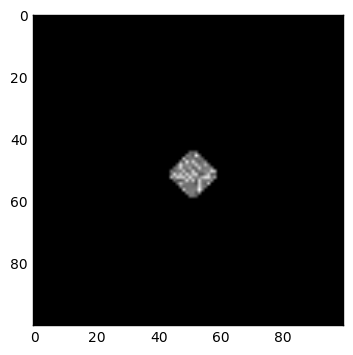

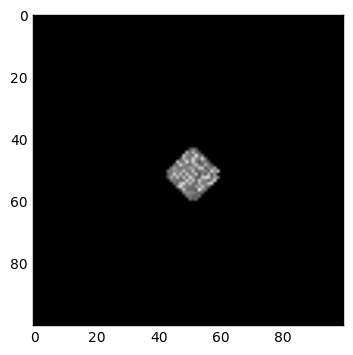

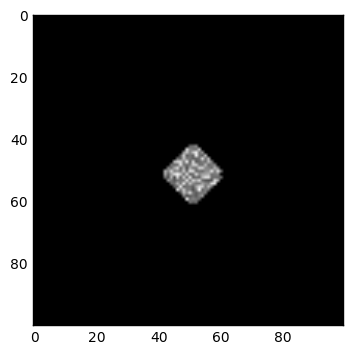

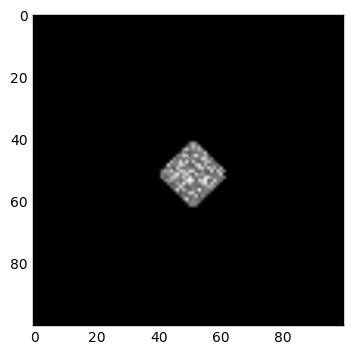

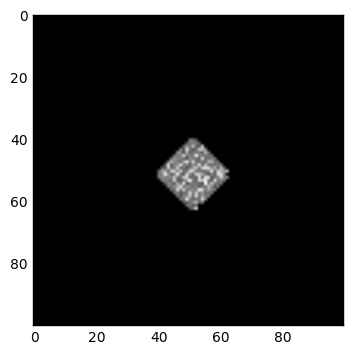

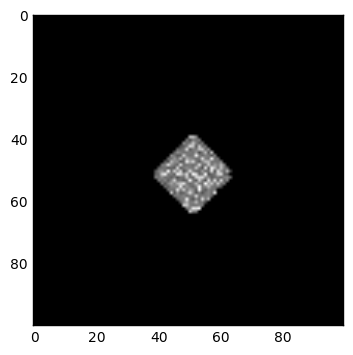

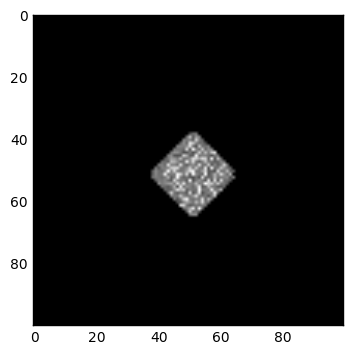

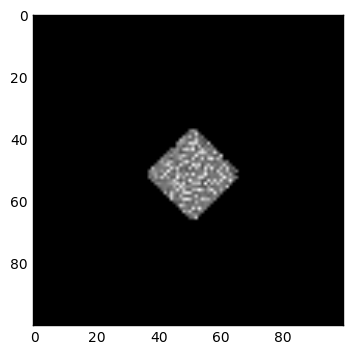

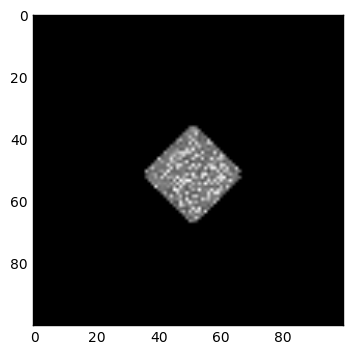

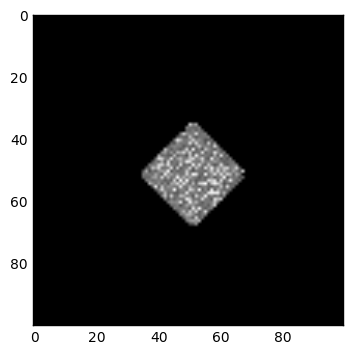

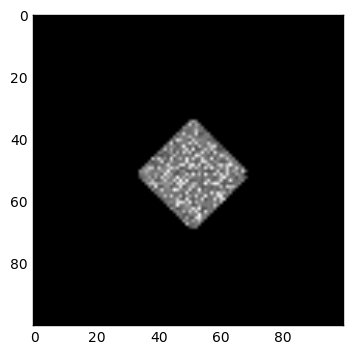

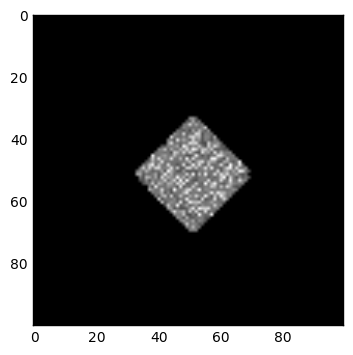

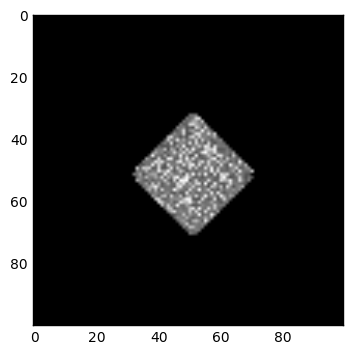

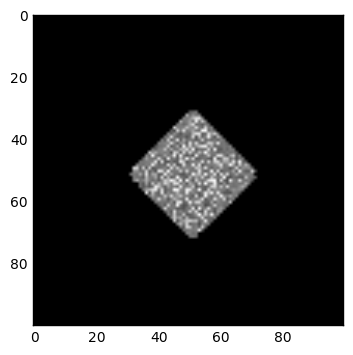

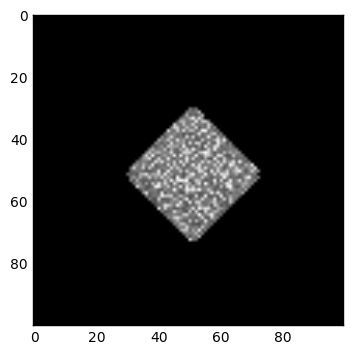

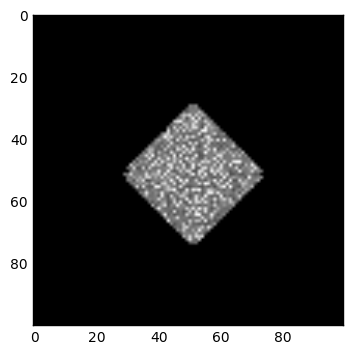

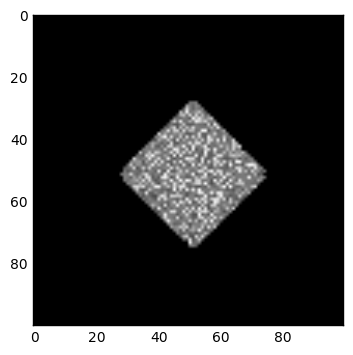

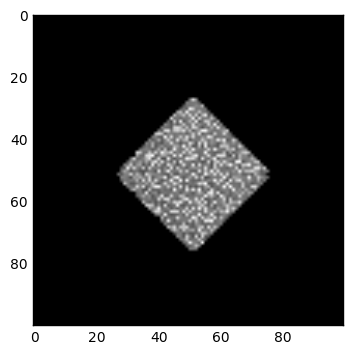

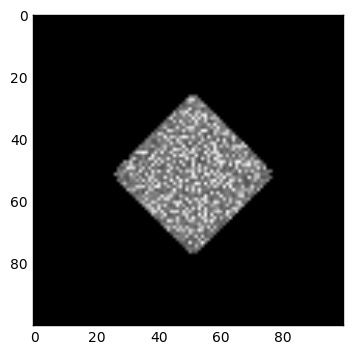

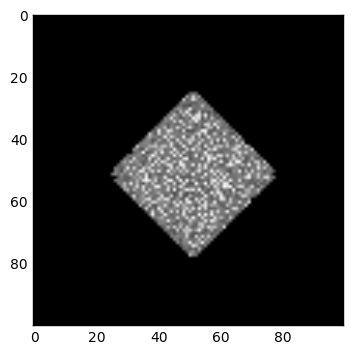

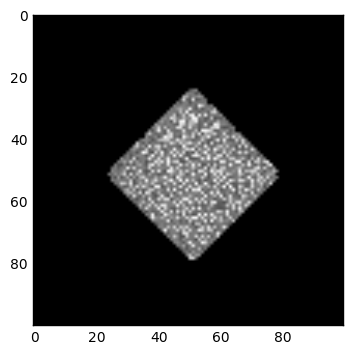

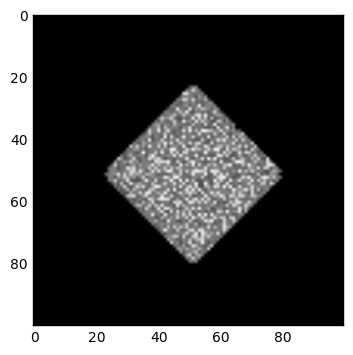

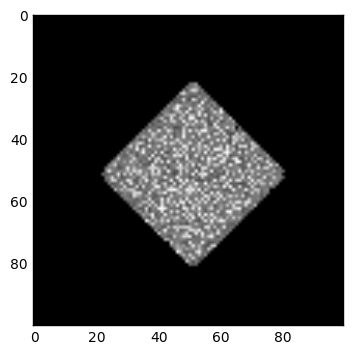

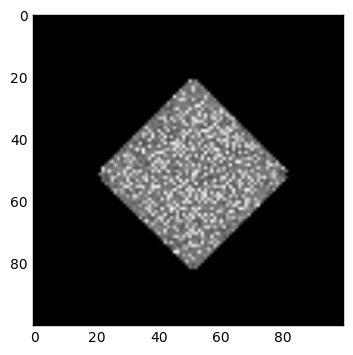

In [ ]:
## growimage 
def synthesize(filename,winsize,shape_newimage,shape_seed = (3,3)):
    # read sample image
    img_sample = io.imread(os.getcwd()+'/Documents/Computer-Vision-534/hw2/Assignment-II-images/'+filename)
#     subs_image = morphology.dilation(img_sample) - img_sample
#     plt.imshow(subs_image);
#     find(subs_image)
    
    # initialize img2bfilled with a random sample from sample image (size: shape_seed) 
    randrow = round(rand()*(img_sample.shape[0]-shape_seed[0]))
    randcol = round(rand()*(img_sample.shape[1]-shape_seed[1]))
    seed_img = img_sample[randrow : randrow + shape_seed[0], randcol : randcol + shape_seed[1]]
    #(left-up corner is the center of img2bfilled)
#     range_in_img2bfilled = (shape_newimage[0]/2 : (shape_newimage[0]/2 + shape_seed[0]),
#                 shape_newimage[1]/2 : (shape_newimage[1]/2 + shape_seed[1]))
    img2bfilled = np.zeros(shape_newimage)
    img2bfilled[shape_newimage[0]/2 : (shape_newimage[0]/2 + shape_seed[0]),
                shape_newimage[1]/2 : (shape_newimage[1]/2 + shape_seed[1])] = seed_img 
    filled_status = np.ones(shape_newimage) == False
    filled_status[shape_newimage[0]/2 : (shape_newimage[0]/2 + shape_seed[0]),
                shape_newimage[1]/2 : (shape_newimage[1]/2 + shape_seed[1])] = True
    
    # Synthesis
    img_new = GrowImage(img_sample,img2bfilled,filled_status, winsize)

    # show image
    plt.imshow(img_sample)
    plt.title('sample image')
    plt.show()
    plt.imshow(img_new)
    plt.title('Sythesized image')
    plt.show()
    
def GrowImage(SampleImage, Image2bfilled, filled_status, winsize):
    MaxErrThreshold = 0.3
    while not filled_status.all():
        progress = 0
        row_idxs,col_idxs = GetUnfilledNeighbors(Image2bfilled, winsize)
        for ridx,colidx in zip(row_idxs,col_idxs):
            Template,validmask = GetNeighborhoodWindow(ridx,colidx,Image2bfilled, filled_status, winsize)
            BestMatches_list = FindMatches(Template, SampleImage,validmask,winsize)
            BestMatch_loc, BestMatch_error= RandomPick(BestMatches_list)
            if BestMatch_error < MaxErrThreshold:
                Image2bfilled[ridx,colidx] = SampleImage[BestMatch_loc]
                progress = 1
                filled_status[ridx,colidx] = True
        # pdb.set_trace()
        plt.imshow(Image2bfilled,cmap='gray')
        plt.show()
        if progress == 0:
            MaxErrThreshold = MaxErrThreshold * 1.1
    return Image

## GetUnfilledNeighbors
def GetUnfilledNeighbors(Image2bfilled, winsize):
    subs_image = morphology.dilation(Image2bfilled) - Image2bfilled
#     pdb.set_trace()
    [row_idxs, col_idxs] = np.where(subs_image!=0)
    # random permutation
    randidx = np.random.permutation(len(row_idxs))
    row_idxs = [row_idxs[idx] for idx in randidx]
    col_idxs = [col_idxs[idx] for idx in randidx]
    # sorted by decreasing number of filled neighbor pixels
    filledsum  = scipy.ndimage.generic_filter(Image2bfilled, np.sum, winsize)
#     pdb.set_trace()
    filledsum_bs = [filledsum[x,y] for x,y in zip(row_idxs,col_idxs)]
#     pdb.set_trace()
    sorted_idx = np.array(filledsum_bs).argsort()[::-1]
    res_row = [row_idxs[i] for i in sorted_idx]
    res_col = [col_idxs[i] for i in sorted_idx]
    return res_row, res_col

## GetNeighborhoodWindow
def GetNeighborhoodWindow(ridx,colidx,Image2bfilled,filled_status, winsize):
    half_winsize = winsize/2
    row_range = range(ridx - half_winsize,ridx + half_winsize + 1)
    col_range = range(colidx - half_winsize,colidx + half_winsize + 1)
    template = np.zeros((winsize,winsize))
    template_filled_status = np.ones((winsize,winsize)) == False
    for r in range(winsize):
        for c in range(winsize):
            if row_range[r] in range(Image2bfilled.shape[0]) and col_range[c] in range(Image2bfilled.shape[1]):
                template[r,c] = Image2bfilled[row_range[r],col_range[c]]
                template_filled_status[r,c] = True
    return template,template_filled_status
    
    
## Find Matches, return locations, corresponding ssd
def FindMatches(Template,SampleImage,ValidMask,winsize):
    Sigma = winsize/6.4
    ErrThreshold = 0.1
    sample_r, sample_c = SampleImage.shape;
    
    GaussMask = gkern(winsize,Sigma)
    maskintotal = np.multiply(ValidMask,GaussMask)
    mask_normalized = maskintotal/maskintotal.sum()
    SSD = np.zeros(SampleImage.shape)
    PixelList = [] # locations of qualified candidates
#     for i,j in zip(range(winsize/2, sample_r - winsize/2-1), range(winsize/2, sample_c - winsize/2-1)): # for each patch in SampleImage
    for i in range(winsize/2, sample_r - winsize/2-1): # for each patch in SampleImage
        for j in range(winsize/2,sample_c- winsize/2-1):
#             pdb.set_trace()
            curr_patch = SampleImage[i-winsize/2:i+winsize/2, j-winsize/2:j+winsize/2]
            dist = (Template-curr_patch)**2
            SSD[i,j] += np.multiply(dist, mask_normalized).sum()
#     pdb.set_trace()
    thr = SSD[SSD!=0].min()*(1+ErrThreshold)
    for i in range(SSD.shape[0]):
        for j in range(SSD.shape[1]):
            if SSD[i,j] <= thr:
                PixelList.append([(i,j),SSD[i,j]])
    return PixelList

def gkern(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def RandomPick(BestMatches):
    ## return the location of the best match randomly from the candidates lists
    return BestMatches[randint(0,len(BestMatches))]


synthesize('T1.gif',20,[100,100])

In [ ]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [ ]:
tmp = makeGaussian(3,1)
tmp2 = np.multiply(tmp,tmp)
tmp3 = scipy.signal.convolve2d(tmp,tmp,mode = 'same')
print tmp2.sum(),tmp3.sum()
print tmp
print tmp2.sum()
print tmp3.sum()



In [21]:
a = [[0,2],[3,4]]
b = [[1,2],[3,4]]
c = [[4,3],[2,1]]
print a,b
print np.multiply(a,b)
print scipy.signal.convolve2d(a,c,mode = 'same')
print scipy.signal.convolve2d(a,b,mode = 'same')


[[0, 2], [3, 4]] [[1, 2], [3, 4]]
[[ 0  4]
 [ 9 16]]
[[ 0  8]
 [12 29]]
[[ 0  2]
 [ 3 16]]


In [26]:
a = np.array(a)
a[a!=0].min()

2

In [23]:
np.nonzero(a)


(array([0, 1, 1]), array([1, 0, 1]))